# Table of contents
1. [Preliminaries](#preliminaries)
2. [Coding PCA](#coding)
3. [Obtaining principal components](#components)
4. [Performing Gradient Boosting Classification with principal components](#classification1)
5. [Performing Gradient Boosting Classification with all features](#classification2)

In this notbook I'm using the Diabetes Health Indicators Dataset https://www.kaggle.com/datasets/julnazz/diabetes-health-indicators-dataset downloaded from Kaggle. I take up a classification task, where I'm using ther Gradeint Boosting Classifier to predict whether a patient has diabetes or not. But first, I aim to reduce the dimensinality of features. I code the Principal Components Analysis and find lower dimensional subspaces of features: first 3-, then 10-dimensional. I compare the classification performance ewith smaller number of features to classification using all original features.

# Preliminaries <a name="preliminaries"></a>

In [1]:
import pandas as pd
from pandasql import sqldf
from pandasql import sqldf
from scipy import stats
import numpy as np
import seaborn as sn
import math
import pylab
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from numpy import linalg as LA
from scipy.sparse.linalg import eigsh

from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler, PowerTransformer, MaxAbsScaler, KBinsDiscretizer, PowerTransformer, QuantileTransformer, RobustScaler
from sklearn.feature_selection import VarianceThreshold

# model training/tuning
from sklearn.pipeline import Pipeline, make_pipeline 
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.dummy import DummyClassifier

# models
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# model validation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, recall_score, accuracy_score, make_scorer


import csv
import warnings
warnings.filterwarnings('always')  # Possibilities: "error", "ignore", "always", "default", "module" or "once"


np.int = int
np.bool= bool


In [2]:
data=pd.read_csv('/Users/elzbietapolak/Desktop/Healthcare_dataset/diabetes_binary_5050split_health_indicators_BRFSS2021.csv')

In [3]:
pd.set_option('display.max_columns', None)
data.describe()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
count,67136.000000,67136.000000,67136.000000,67136.000000,67136.000000,67136.000000,67136.000000,67136.000000,67136.000000,67136.000000,67136.000000,67136.000000,67136.000000,67136.000000,67136.000000,67136.000000,67136.000000,67136.000000,67136.000000,67136.000000,67136.000000,67136.000000
mean,0.500000,0.548320,0.500238,0.976227,30.288340,0.440151,0.058866,0.136633,0.717260,0.605919,0.810608,0.049109,0.967260,0.066522,2.774756,4.230845,5.136752,0.231202,0.493431,8.501743,5.035912,6.563885
std,0.500004,0.497663,0.500004,0.152341,7.095737,0.496409,0.235375,0.343462,0.450334,0.488656,0.391822,0.216098,0.177955,0.249194,1.073759,8.323138,9.593837,0.421605,0.499961,3.019624,0.981610,2.422641
min,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,1.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,7.000000,4.000000,5.000000
50%,0.500000,1.000000,1.000000,1.000000,29.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,9.000000,5.000000,7.000000
75%,1.000000,1.000000,1.000000,1.000000,34.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,3.000000,4.000000,5.000000,0.000000,1.000000,11.000000,6.000000,8.000000
max,1.000000,1.000000,1.000000,1.000000,99.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,30.000000,30.000000,1.000000,1.000000,13.000000,6.000000,11.000000


In [4]:
# Showing all columns
pd.set_option('display.max_columns', None)



In [5]:
RANDOM=41 

In [6]:
# Using 200 samples for training:
data1=data.sample(200,random_state=RANDOM, axis=0)


In [7]:
data1.describe()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.00000,200.000000,200.000000,200.000000,200.000000
mean,0.515000,0.490000,0.500000,0.965000,30.110000,0.420000,0.060000,0.130000,0.745000,0.625000,0.795000,0.040000,0.965000,0.070000,2.715000,3.765000,3.475000,0.21000,0.480000,8.455000,5.045000,6.695000
std,0.501029,0.501154,0.501255,0.184241,6.590529,0.494797,0.238083,0.337147,0.436955,0.485338,0.404715,0.196451,0.184241,0.255787,0.958315,8.016928,7.778296,0.40833,0.500854,3.065118,0.947345,2.500648
min,0.000000,0.000000,0.000000,0.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000,1.000000,2.000000,1.000000
25%,0.000000,0.000000,0.000000,1.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.00000,0.000000,6.000000,4.000000,5.000000
50%,1.000000,0.000000,0.500000,1.000000,29.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.00000,0.000000,9.000000,5.000000,7.000000
75%,1.000000,1.000000,1.000000,1.000000,33.250000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,3.000000,3.000000,2.000000,0.00000,1.000000,11.000000,6.000000,9.000000
max,1.000000,1.000000,1.000000,1.000000,51.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,30.000000,30.000000,1.00000,1.000000,13.000000,6.000000,11.000000


The sample of 200 patients is still balanced (the mean is almost the same as for the full dataframe), so this is good for training.

# Coding PCA  <a name="coding"></a>

Now I focus on the classification task, using xboost random forest. There are 22 columns, so the features live in a 22 dimensional space. I will reduce dimensionality by coding the PCA procedure by hand and picking a smaller dimensional subspace. Then I perform classification. Finally, I will perfrom the classification using all 22 features and will compare corectness of the two approaches. 



In [8]:
# Dropping 'diabetes_binary' column:
X1=data1.drop(['Diabetes_binary'], axis=1)

In [9]:
len(data.columns)

22

In [10]:
# Normalizing the data:

# 1. Computing the mean for each column:
def mean(x):
    return sum(x)/len(x)

# 2. Computing standard deviation:

def st_dev(x):
    vec=((np.array(x)-[mean(x)]*len(x)))**2;
    return math.sqrt(sum(vec)/len(x))

# 3. Computing the standardized vector:
def vec_to_normal(x):
    vec1=(x-([mean(x)]*len(x)))/st_dev(x)
    #vec=[0]*len(x);
   # vectorize
   # for i in range(len(x)):
   #     vec[i]=(x[i]-mean(x))/st_dev(x)
    return vec1
        

In [11]:
# Normalizing the data 2-dimensional array
def standard_data(Y):
    StandardY=np.zeros_like(Y);
    for i in range(len(Y.columns)):
        StandardY[:,i]=vec_to_normal(Y.iloc[:, i])
    return pd.DataFrame(StandardY)
        

In [12]:
# Applying the standardizer to the features:
StandardData=pd.DataFrame(standard_data(X1).copy())

Now each of the features is normalized. For example, looking at the description below, the mean is zero a d standard deviation is 1:

In [13]:
StandardData.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
count,2.000000e+02,200.000000,2.000000e+02,2.000000e+02,2.000000e+02,2.000000e+02,2.000000e+02,2.000000e+02,2.000000e+02,2.000000e+02,2.000000e+02,2.000000e+02,2.000000e+02,2.000000e+02,2.000000e+02,2.000000e+02,2.000000e+02,2.000000e+02,2.000000e+02,2.000000e+02,2.000000e+02
mean,4.662937e-17,0.000000,3.733125e-16,6.217249e-17,1.310063e-16,-1.026956e-16,-2.331468e-16,-1.310063e-16,-3.996803e-17,-1.176836e-16,1.265654e-16,2.733924e-16,-2.114975e-16,1.620926e-16,3.996803e-17,-1.584843e-16,6.883383e-17,1.165734e-16,-9.436896e-18,2.287059e-16,-7.049916e-17
std,1.002509e+00,1.002509,1.002509e+00,1.002509e+00,1.002509e+00,1.002509e+00,1.002509e+00,1.002509e+00,1.002509e+00,1.002509e+00,1.002509e+00,1.002509e+00,1.002509e+00,1.002509e+00,1.002509e+00,1.002509e+00,1.002509e+00,1.002509e+00,1.002509e+00,1.002509e+00,1.002509e+00
min,-9.801961e-01,-1.000000,-5.250850e+00,-2.298437e+00,-8.509629e-01,-2.526456e-01,-3.865557e-01,-1.709260e+00,-1.290994e+00,-1.969276e+00,-2.041241e-01,-5.250850e+00,-2.743516e-01,-1.794091e+00,-4.708098e-01,-4.478771e-01,-5.155800e-01,-9.607689e-01,-2.438310e+00,-3.222312e+00,-2.283125e+00
25%,-9.801961e-01,-1.000000,1.904453e-01,-7.773007e-01,-8.509629e-01,-2.526456e-01,-3.865557e-01,-1.709260e+00,-1.290994e+00,5.078008e-01,-2.041241e-01,1.904453e-01,-2.743516e-01,-7.479738e-01,-4.708098e-01,-4.478771e-01,-5.155800e-01,-9.607689e-01,-8.029578e-01,-1.105851e+00,-6.795252e-01
50%,-9.801961e-01,0.000000,1.904453e-01,-1.688461e-01,-8.509629e-01,-2.526456e-01,-3.865557e-01,5.850486e-01,7.745967e-01,5.078008e-01,-2.041241e-01,1.904453e-01,-2.743516e-01,2.981434e-01,-4.708098e-01,-4.478771e-01,-5.155800e-01,-9.607689e-01,1.782534e-01,-4.762038e-02,1.222744e-01
75%,1.020204e+00,1.000000,1.904453e-01,4.776368e-01,1.175139e+00,-2.526456e-01,-3.865557e-01,5.850486e-01,7.745967e-01,5.078008e-01,-2.041241e-01,1.904453e-01,-2.743516e-01,2.981434e-01,-9.566254e-02,-1.901061e-01,-5.155800e-01,1.040833e+00,8.323941e-01,1.010610e+00,9.240741e-01
max,1.020204e+00,1.000000,1.904453e-01,3.177654e+00,1.175139e+00,3.958114e+00,2.586949e+00,5.850486e-01,7.745967e-01,5.078008e-01,4.898979e+00,1.904453e-01,3.644957e+00,2.390378e+00,3.280663e+00,3.418687e+00,1.939563e+00,1.040833e+00,1.486535e+00,1.010610e+00,1.725874e+00


 Now we can define the covariance matrix:

In [14]:
def Covariance(Y):
    Cov=np.zeros((21, 21))
    for i in range(21):
        for j in range(21):
            Cov[i,j]=np.dot(Y.iloc[:,i],Y.iloc[:,j])
    return Cov

Obtaining a 21x21 covariance matrix for our case:

In [15]:
Covariance(StandardData)

array([[ 2.00000000e+02,  6.00120036e+01,  2.64499872e+01,
         4.84487595e+01, -1.28075280e+01,  3.47036006e+01,
         3.72357326e+01, -2.29935682e+01, -3.40890719e+01,
         4.45963060e-01, -9.39158919e+00,  3.73347556e+01,
         1.09762607e+00,  5.84478004e+01, -1.49338468e+00,
         1.99683556e+01,  4.13528809e+01, -1.21721744e+01,
         4.73758100e+01, -2.41536554e+01, -2.09391772e+01],
       [ 6.00120036e+01,  2.00000000e+02,  3.80890693e+01,
         1.15606369e+01,  8.88178420e-16,  1.68430384e+01,
         2.37880413e+01, -6.88292486e+00, -2.06559112e+00,
         1.73395389e+01, -1.02062073e+01,  3.80890693e+01,
        -2.35158541e+01,  3.66141038e+01, -1.31301531e+01,
         1.97194791e+01,  2.94617170e+01, -1.60128154e+01,
         5.98538814e+01, -3.17469205e+00, -2.80629879e+00],
       [ 2.64499872e+01,  3.80890693e+01,  2.00000000e+02,
         3.04343563e+01, -6.61477276e-01, -1.32889529e+01,
        -1.45617486e+00, -9.79994755e+00,  4.21480946e

In [16]:
Covariance(StandardData).shape

(21, 21)

In [17]:
# Finding eigenvalues of the Covariance matrix:
eigenvalues, eigenvectors=LA.eig(Covariance(X1))

Usually one can see when the magnitude of eigenvalues drops dramatically. For example, here we have first 5 eignevalues:

In [18]:
eigenvectors[0]

array([-0.01510438,  0.00068707,  0.00663934, -0.01264726, -0.03438372,
        0.04136068, -0.15028232,  0.49093324,  0.12211904,  0.37899596,
        0.14709396,  0.08535123, -0.68317735,  0.03739872,  0.03384476,
       -0.02799754,  0.06893149,  0.01863077,  0.18631774, -0.18837369,
        0.01564729])

In [19]:
eigenvalues[:5]

array([224984.77852491,  16434.15040836,   8157.10690679,   2685.39147498,
         1653.40382164])

need this thing about most viarianve in the first eigenvalue or something. The difference in magnitude between the top eigenvalues ans the 20th one:

In [20]:
eigenvalues[0]/eigenvalues[19] 

12473.606596678628

Plotting the histogram of eigenvalues:


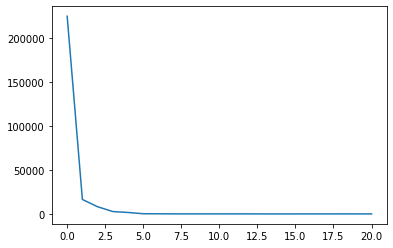

In [21]:
xpoints = np.array([i for i in range(len(eigenvalues))])
plt.plot(xpoints, eigenvalues)
plt.show()

Plotting the histogram of three first eigenvalues:


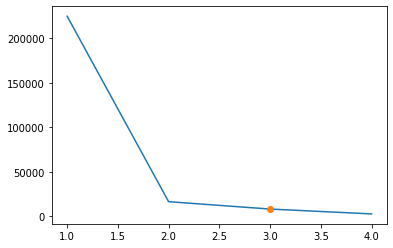

In [22]:
xpoints = np.array([1,2,3,4])
plt.plot(xpoints, eigenvalues[:4])
plt.plot(xpoints[2], eigenvalues[2], 'o')
plt.show()

We see, we really just need three principal vectors, with the frist one completely dominating. 

# Obtaining principal components <a name="components"></a>

The last step is to project our standardized data set onto the subspace spanned by the three eigenvectors we chose!

In [23]:
PCAdata=pd.DataFrame(np.dot(StandardData,eigenvectors[:,:3]))

In [24]:
PCAdata

,0,1,2
0,1.182421,0.562326,-0.174723
1,-0.072040,0.575026,0.183837
2,0.387350,0.682951,0.041210
3,-0.062420,0.738623,0.047304
4,-1.791896,-1.986760,-2.449509
...,...,...,...
195,0.113962,0.612797,-0.256987
196,-0.399551,0.338838,0.090858
197,-0.171515,0.363024,-0.273039
198,-1.193963,0.810282,0.048792


# Performing Gradient Boosting Classification with principal components <a name="classification1"></a>

Using just three principal components in the binary classification task:

In [25]:
# Creating a new data frame with three features:
XPCA=pd.DataFrame(PCAdata)
y=data1['Diabetes_binary'].values

In [26]:
XPCA

,0,1,2
0,1.182421,0.562326,-0.174723
1,-0.072040,0.575026,0.183837
2,0.387350,0.682951,0.041210
3,-0.062420,0.738623,0.047304
4,-1.791896,-1.986760,-2.449509
...,...,...,...
195,0.113962,0.612797,-0.256987
196,-0.399551,0.338838,0.090858
197,-0.171515,0.363024,-0.273039
198,-1.193963,0.810282,0.048792


In [27]:
feature_list=['0','1','2']

In [28]:
RANDOM_STATE=1

In [29]:
X_train, X_test, y_train, y_test = train_test_split(XPCA, y, test_size=0.33, random_state=RANDOM_STATE)

In [30]:
# check size of data splits
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(134, 3)
(66, 3)
(134,)
(66,)


# Defining and running the pipleline for the Gradient Boosting Classifier
# with three principal components (extreme dimensionality reduction):

In [31]:
np.object=object
clf = GradientBoostingClassifier(n_estimators=50, learning_rate=1.0,max_depth=1, random_state=0)
clf1=clf.fit(X_train, y_train)

In [32]:
# Defining metrics of the model: the score and confusion matrix:

def Metrics(predictions):
    print(f'the score on the training set set is ' +str(clf.score(X_train,y_train)) )
    print(f'the score on the test set set is ' +str(clf.score(X_test,y_test)) )
    print(classification_report(y_test,predictions, digits=5))
    conf=confusion_matrix(y_test,predictions,normalize='all')
    displayCM=ConfusionMatrixDisplay(confusion_matrix=conf,display_labels=clf.classes_)
    displayCM.plot()

In [33]:
predictions=clf.predict(X_test)

the score on the training set set is 0.917910447761194
the score on the test set set is 0.6515151515151515
              precision    recall  f1-score   support

         0.0    0.64516   0.62500   0.63492        32
         1.0    0.65714   0.67647   0.66667        34

    accuracy                        0.65152        66
   macro avg    0.65115   0.65074   0.65079        66
weighted avg    0.65133   0.65152   0.65127        66



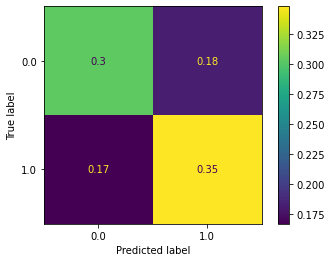

In [34]:
Metrics(predictions)

# The score for three principal components is not so great, let's use first 10 principal components!

In [35]:
# Creating a new data frame with ten features:
PCAdata10 =pd.DataFrame(np.dot(StandardData,eigenvectors[:,:10]))
XPCA10=pd.DataFrame(PCAdata10)
y=data1['Diabetes_binary'].values

In [36]:
X10_train, X10_test, y10_train, y10_test = train_test_split(XPCA10, y, test_size=0.33, random_state=RANDOM_STATE)

In [37]:
clf10 = GradientBoostingClassifier(n_estimators=50, learning_rate=1.0,max_depth=1, random_state=0).fit(X10_train, y10_train)

In [38]:
predictions10=clf10.predict(X10_test)

In [39]:
def Metrics10(predictions):
    print(f'the score on the training set is ' +str(clf10.score(X10_train,y10_train)) )
    print(f'the score on the test set set is ' +str(clf10.score(X10_test,y10_test)) )
    print(classification_report(y10_test,predictions10, digits=5))
    conf10=confusion_matrix(y10_test,predictions10,normalize='all')
    displayCM=ConfusionMatrixDisplay(confusion_matrix=conf10,display_labels=clf.classes_)
    displayCM.plot()

the score on the training set is 0.9850746268656716
the score on the test set set is 0.7121212121212122
              precision    recall  f1-score   support

         0.0    0.72414   0.65625   0.68852        32
         1.0    0.70270   0.76471   0.73239        34

    accuracy                        0.71212        66
   macro avg    0.71342   0.71048   0.71046        66
weighted avg    0.71310   0.71212   0.71112        66



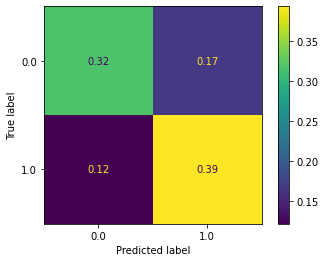

In [40]:
Metrics10(predictions10)

# By using 10 vectors we improved accuracy from 65% to 71%. We only used   
# about a half of the original number of features.

# Performing Gradient Boosting Classification with all features <a name="classification2"></a>

In [41]:
Xall_train, Xall_test, y_train, y_test = train_test_split(StandardData, y, test_size=0.33, random_state=RANDOM_STATE)

In [42]:
clfall = GradientBoostingClassifier(n_estimators=50, learning_rate=1.0,max_depth=1, random_state=0).fit(Xall_train, y_train)

In [43]:
predictionsAll=clfall.predict(Xall_test)

In [44]:
def MetricsAll(predictions):
    print(f'the score on the training set is ' +str(clfall.score(Xall_train,y_train)) )
    print(f'the score on the test set set is ' +str(clfall.score(Xall_test,y_test)) )
    print(classification_report(y_test,predictionsAll, digits=5))
    confAll=confusion_matrix(y_test,predictionsAll,normalize='all')
    displayCM=ConfusionMatrixDisplay(confusion_matrix=confAll,display_labels=clfall.classes_)
    displayCM.plot()

the score on the training set is 0.8582089552238806
the score on the test set set is 0.7272727272727273
              precision    recall  f1-score   support

         0.0    0.71875   0.71875   0.71875        32
         1.0    0.73529   0.73529   0.73529        34

    accuracy                        0.72727        66
   macro avg    0.72702   0.72702   0.72702        66
weighted avg    0.72727   0.72727   0.72727        66



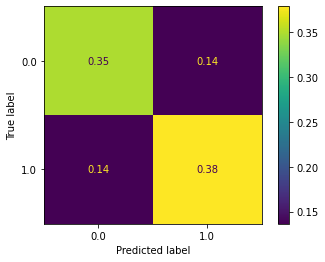

In [45]:
MetricsAll(predictions)

# Using all features improved the score on the test set by only 1%.